# 使用LSTM和GRU深度学习，对u和v进行时序预测

## 定义数据预处理相关类及函数

In [66]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import matplotlib.pyplot as plt

lengths = 100
targets = 50

def data_prediction_to_f_and_t(data, num_features, num_targets):
    features, target = [], []
    for i in range(((len(data) - num_features - num_targets)) + 1) :
        f = data[i:i+num_features]
        t = data[i+num_features:i+num_features+num_targets]
        features.append(f)
        target.append(t)
        
    # print(np.array(features).shape,np.array(target).shape)
    return np.array(features), np.array(target)

class dataset_to_Dataset(Dataset):
    def __init__(self,data_features,data_target):
        self.len = len(data_features)
        self.features = torch.from_numpy(data_features)
        self.target = torch.from_numpy(data_target)
        
    def __getitem__(self,index):
        return self.features[index],self.target[index]
    
    def __len__(self):
        return self.len
    
def dataset_split_4sets(data_features, data_target, ratio=0.8):
    split_index = int(ratio*len(data_features))
    train_features = data_features[:split_index]
    train_target = data_target[:split_index]
    test_features = data_features[split_index:]
    test_target = data_target[split_index:]
    return train_features, train_target, test_features, test_target

In [67]:
import pandas as pd

u_path = r"E:\PKU_ThirdGrade_Autumn\机器学习基础\Dataset\Dataset\data_0\u.csv"
v_path = r"E:\PKU_ThirdGrade_Autumn\机器学习基础\Dataset\Dataset\data_0\v.csv"
df = pd.read_csv(u_path,header=None)
u_wind = list(df.iloc[:,0].values)
df = pd.read_csv(v_path,header=None)
v_wind = list(df.iloc[:,0].values)
y = u_wind
x = list(range(1,len(u_wind)+1))

## 定义GRU神经网络

In [68]:
import torch
import torch.nn as nn

INPUT_SIZE = 1 # 子序列一个数描述的特征数量，只有一个就是1
HIDDEN_SIZE = 64 # 隐藏状态的特征数

# 定义我们的类
class GRU(nn.Module):
    def __init__(self):
        super(GRU, self).__init__()
        self.gru = nn.GRU(
            input_size=INPUT_SIZE,# 传入我们上面定义的参数
            hidden_size=HIDDEN_SIZE,# 传入我们上面定义的参数
            batch_first=True,# 为什么设置为True上面解释过了
        )
        self.mlp = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, 32), # 加入线性层的原因是，GRU的输出，参考官网为(batch_size, seq_len, hidden_size)
            nn.LeakyReLU(),             # 这边的多层全连接，根据自己的输出自己定义就好，
            nn.Linear(32, 16),          # 我们需要将其最后打成（batch_size, output_size）比如单值预测，这个output_size就是1，
            nn.LeakyReLU(),             # 这边我们等于targets
            nn.Linear(16, targets)      # 这边输出的（batch_size, targets）且这个targets是上面一个模块已经定义好了
        )

    def forward(self, input):
        output, h_n = self.gru(input, None)# output:(batch_size, seq_len, hidden_size)，h0可以直接None
        # print(output.shape)
        output = output[:, -1, :]# output:(batch_size, hidden_size)
        output = self.mlp(output)# 进过一个多层感知机，也就是全连接层，output:(batch_size, output_size)
        return output


In [69]:
model = GRU()
print(model)

GRU(
  (gru): GRU(1, 64, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=16, out_features=50, bias=True)
  )
)


## 定义LSTM神经网络

In [70]:
'''LSTM完整模块'''

# 用户：Ejemplarr
# 编写时间:2022/3/24 22:09
import torch
import torch.nn as nn

INPUT_SIZE = 1 # The number of expected features in the input x
HIDDEN_SIZE = 64 # The number of features in the hidden state h

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.gru = nn.LSTM(
            input_size=INPUT_SIZE,# 传入我们上面定义的参数
            hidden_size=HIDDEN_SIZE,# 传入我们上面定义的参数
            batch_first=True,# 为什么设置为True上面解释过了
        )
        self.mlp = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, 32), # 加入线性层的原因是，GRU的输出，参考官网为(batch_size, seq_len, hidden_size)
            nn.LeakyReLU(),             # 这边的多层全连接，根据自己的输出自己定义就好，
            nn.Linear(32, 16),          # 我们需要将其最后打成（batch_size, output_size）比如单值预测，这个output_size就是1，
            nn.LeakyReLU(),             # 这边我们等于targets
            nn.Linear(16, targets)      # 这边输出的（batch_size, targets）且这个targets是上面一个模块已经定义好了
        )

    def forward(self, input):
        output, h_n = self.gru(input, None)# output:(batch_size, seq_len, hidden_size)，h0可以直接None
        # print(output.shape)
        output = output[:, -1, :]# output:(batch_size, hidden_size)
        output = self.mlp(output)# 进过一个多层感知机，也就是全连接层，output:(batch_size, output_size)
        return output

In [71]:
model = LSTM()
print(model)

LSTM(
  (gru): LSTM(1, 64, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=16, out_features=50, bias=True)
  )
)


# 定义训练过程

cuda
GRU:loss: 13.017783185701038
GRU:loss: 1.7970178924847482
GRU:loss: 1.5495321344151054
GRU:loss: 1.2637022047715132
GRU:loss: 0.9945124548708284
GRU:loss: 1.1042644646451918
GRU:loss: 1.016300264659316
GRU:loss: 0.840462526921616
GRU:loss: 0.6695162277928618
GRU:loss: 0.6066598018761291
GRU:loss: 0.48679900139916776
GRU:loss: 0.4356710151184437
GRU:loss: 0.432201882754994
GRU:loss: 0.36309616933035294
GRU:loss: 0.35874374240290285
GRU:loss: 0.3441586168006409
GRU:loss: 0.32228884928274987
GRU:loss: 0.3298574986672679
GRU:loss: 0.3076587338347075
GRU:loss: 0.2739195034687602
GRU:loss: 0.2692323985661185
GRU:loss: 0.27746574368847665
GRU:loss: 0.4475809389508741
GRU:loss: 0.23237570457940185
GRU:loss: 0.21880777881069238
GRU:loss: 0.2062500118083039
GRU:loss: 0.19489425965259935
GRU:loss: 0.18398312830994296
GRU:loss: 0.21350807208827763
GRU:loss: 0.1802465840307779
GRU:loss: 0.16821404375828977
GRU:loss: 0.16461219277752692
GRU:loss: 0.1663874738828041
GRU:loss: 0.18603255905557511

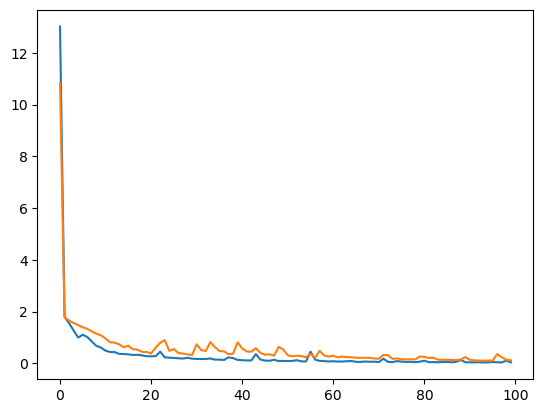

In [72]:
import torch.nn as nn
import torch.optim as optim
import time
import torch

BATCH_SIZE = 16
EPOCH = 100
LEARN_RATE = 1e-3

dataset_features, dataset_target = data_prediction_to_f_and_t(y, lengths, targets)
dataset_features = dataset_features.astype(np.float32)
dataset_target = dataset_target.astype(np.float32)
trian_features, train_target, test_features, test_target = dataset_split_4sets(dataset_features, dataset_target)
train_set = dataset_to_Dataset(data_features=trian_features, data_target=train_target)

train_set_iter = DataLoader(dataset=train_set,# 将数据封装进Dataloader类
                            batch_size=BATCH_SIZE,
                            shuffle=True,  # 打乱batch与batch之间的顺序
                            drop_last=True)# drop_last = True表示最后不够一个batch就舍弃那些多余的数据

# gpu的定义
device = ('cuda'if torch.cuda.is_available else 'cpu')
print(device)

# 网络的实例化
net_gru = GRU().to(device)
net_lstm = LSTM().to(device)

# 优化器的定义
optim_gru = optim.Adam(params=net_gru.parameters(), lr=LEARN_RATE)
optim_lstm = optim.Adam(params=net_lstm.parameters(),lr=LEARN_RATE)

# 损失函数的定义
loss_fuc = nn.MSELoss()

loss_gru = []
def train_for_gru(data, device, loss_fuc, net, optim, Epoch):
    for epoch in range(Epoch):
        loss_print = []
        for batch_idx, (x, y) in enumerate(data):
            x = x.reshape([BATCH_SIZE, lengths, 1])
            x = x.to(device)
            y = y.reshape((len(y),targets))
            y = y.to(device)
            y_pred = net(x)
            loss = loss_fuc(y, y_pred)
            loss_print.append(loss.item())
            # 三大步
            # 网络的梯度值更为0
            net.zero_grad()
            # loss反向传播
            loss.backward()
            # 优化器更新
            optim.step()
        print('GRU:loss:',sum(loss_print)/len(data))
        loss_gru.append(sum(loss_print)/len(data))

loss_lstm = []
def train_for_lstm(data, device, loss_fuc, net, optim, Epoch):
    for epoch in range(Epoch):
        loss_print = []
        for batch_idx, (x, y) in enumerate(data):
            x = x.reshape([BATCH_SIZE, lengths, 1])
            x = x.to(device)
            # print(y.shape)
            y = y.reshape((len(y),targets))
            y = y.to(device)
            # print(y.shape)
            y_pred = net(x)
            loss = loss_fuc(y, y_pred)
            loss_print.append(loss.item())
            # 三大步
            # 网络的梯度值更为0
            net.zero_grad()
            # loss反向传播
            loss.backward()
            # 优化器更新
            optim.step()
        print('LSTM:loss:',sum(loss_print)/len(data))
        loss_lstm.append(sum(loss_print)/len(data))

start = time.perf_counter()
train_for_gru(train_set_iter, device, loss_fuc, net_gru, optim_gru, EPOCH)
train_for_lstm(train_set_iter, device, loss_fuc, net_lstm, optim_lstm, EPOCH)
end = time.perf_counter()
print('训练时间为：{:.2f}s'.format(end-start))
#保存模型
torch.save(net_gru.state_dict(), 'gru.pt')
torch.save(net_lstm.state_dict(), 'lstm.pt')
loss_x = list(range(len(loss_gru)))
plt.plot(loss_x, loss_gru)
loss_x = list(range(len(loss_lstm)))
plt.plot(loss_x, loss_lstm)

## 检测网络效果

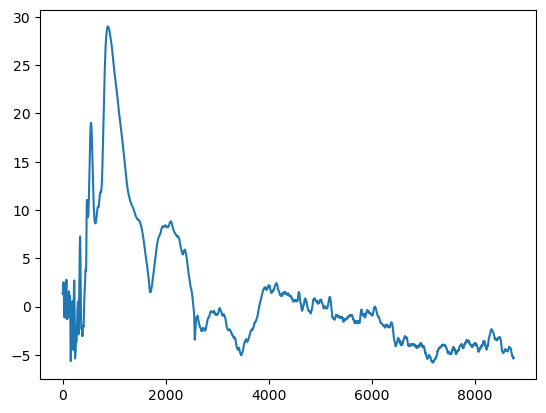

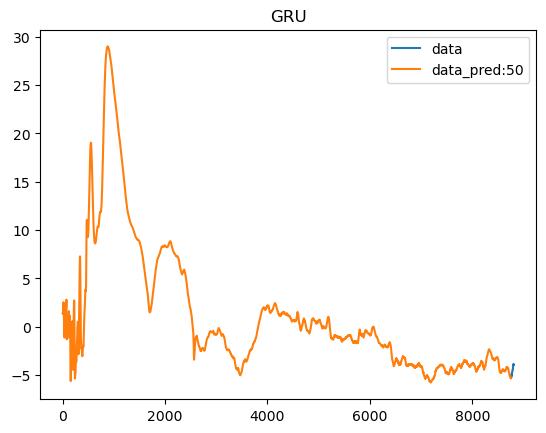

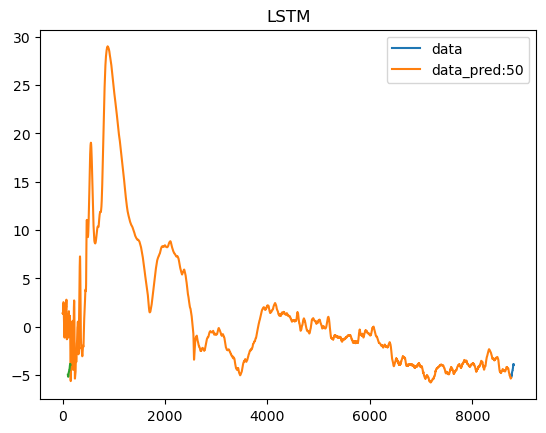

In [73]:
# 导入保存好的网络
net_gru = GRU().to(device)
net_gru.load_state_dict(torch.load('gru.pt'))
net_lstm = LSTM().to(device)
net_lstm.load_state_dict(torch.load('lstm.pt'))

# 定义测试函数
def y_pred_to_numpy(y_pred):
    '''
    :param y_pred: 网络的输出
    :return: 一个numpy数组
    '''
    y_pred = y_pred.detach().cpu().numpy()
    return y_pred

def test_for_gru(dataset_features):
    # dataset_features = dataset_features.reshape([len(dataset_features), lengths, 1])
    # print(dataset_features.shape)
    needed_x = list(y[-1 * lengths - 1:-1])
    needed_x = np.array(needed_x)
    needed_x = needed_x.reshape([1, lengths, 1])
    needed_x = needed_x.astype(np.float32)
    y_pred = net_gru(torch.from_numpy(needed_x).to(device))
    y_pred = y_pred_to_numpy(y_pred)
    y_pred = y_pred.reshape(y_pred.size,1)
    temp_x = list(range(len(y),len(y)+targets))
    plt.plot(temp_x, y_pred)
    # y_pred = net_gru(torch.from_numpy(dataset_features).to(device))
    # y_pred = y_pred_to_numpy(y_pred)
    # print(y_pred.shape)
    # y_pred = y_pred.reshape(y_pred.size,1)
    # print(y_pred.shape)
    plt.plot(x, y)
    # plt.plot(x[lengths:y_pred.size+lengths], y_pred)
    plt.legend(('data', 'data_pred:{}'.format(targets)), loc='upper right')
    plt.title('GRU')
    plt.show()

def test_for_lstm(dataset_features):
    needed_x = list(y[-1 * lengths - 1:-1])
    needed_x = np.array(needed_x)
    needed_x = needed_x.reshape([1, lengths, 1])
    needed_x = needed_x.astype(np.float32)
    y_pred = net_gru(torch.from_numpy(needed_x).to(device))
    y_pred = y_pred_to_numpy(y_pred)
    y_pred = y_pred.reshape(y_pred.size,1)
    temp_x = list(range(len(y),len(y)+targets))
    plt.plot(temp_x, y_pred)
    plt.plot(x, y)
    plt.plot(x[lengths:y_pred.size+lengths], y_pred)
    plt.legend(('data', 'data_pred:{}'.format(targets)), loc='upper right')
    plt.title('LSTM')
    plt.show()

plt.plot(x, y)
plt.show()
test_for_gru(dataset_features)
test_for_lstm(dataset_features)